In [1]:
import numpy as np
from hcipy import *
import matplotlib.pyplot as plt
from astropy.io import fits
import time
from scipy import ndimage
plt.rcParams.update({'font.size': 14})

In [2]:
#lantern propagation functions

def prop_6p_vfn_c0(prop,lant_modes,dx,dxi,wfe=None,tt_x=0,tt_y=0):
    if wfe is not None:
        wf = Wavefront(aperture*np.exp(1j*wfe)*np.exp(1j*2*np.pi*(tt_x)*pupil_grid.x)*np.exp(1j*2*np.pi*(tt_y)*pupil_grid.y))
    else:
        wf = Wavefront(aperture*np.exp(1j*2*np.pi*(tt_x)*pupil_grid.x)*np.exp(1j*2*np.pi*(tt_y)*pupil_grid.y))
    foc_c0 = prop.forward(wf)
    output = np.zeros(num_modes)
    for k in range(num_modes):
        overlap_integrand_c0 = np.conj(lant_modes[k])*foc_c0.electric_field*dx #NOTE: lantern modes don't need dx factor unlike in previous simulations
        tot_intensity_c0 = np.sum(np.square(np.abs(wf.electric_field)),axis=None)*dxi**2
        output[k] = np.square(np.abs(np.sum(overlap_integrand_c0)))/tot_intensity_c0
    return output

def prop_6p_vfn_c0_normLP(prop,lant_modes,dx,dxi,wfe=None,tt_x=0,tt_y=0):
    if wfe is not None:
        wf = Wavefront(aperture*np.exp(1j*wfe)*np.exp(1j*2*np.pi*(tt_x)*pupil_grid.x)*np.exp(1j*2*np.pi*(tt_y)*pupil_grid.y))
    else:
        wf = Wavefront(aperture*np.exp(1j*2*np.pi*(tt_x)*pupil_grid.x)*np.exp(1j*2*np.pi*(tt_y)*pupil_grid.y))
    foc_c0 = prop.forward(wf)
    output = np.zeros(num_modes)
    for k in range(num_modes):
        overlap_integrand_c0 = np.conj(lant_modes[k])*foc_c0.electric_field*dx**2
        tot_intensity_c0 = np.sum(np.square(np.abs(wf.electric_field)),axis=None)*dxi**2
        output[k] = np.square(np.abs(np.sum(overlap_integrand_c0)))/tot_intensity_c0
    return output

102


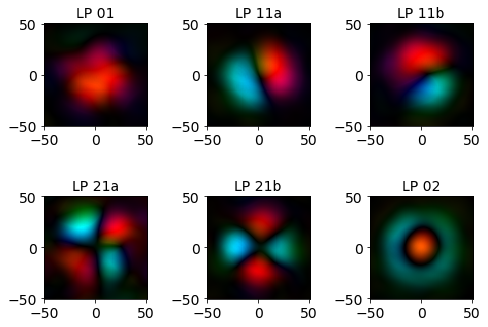

In [3]:
#load measured E fields
modes_shaped = np.load('shaped_fields.npy')
print(modes_shaped.shape[1])
num_modes = 6
lp_mode_names = ['LP 01', 'LP 11a', 'LP 11b', 'LP 21a', 'LP 21b', 'LP 02']

focal_dim = modes_shaped.shape[1]
focal_extent = modes_shaped.shape[1]
focal_grid = make_uniform_grid([focal_dim,focal_dim],[focal_extent,focal_extent])

lant_modes = []
for n in range(num_modes):
    lant_modes.append(Field(modes_shaped[n].ravel(),focal_grid))
    
plt.figure(figsize=[7,5])
for n in range(len(lant_modes)):
    plt.subplot(2,3,n+1)
    imshow_field(lant_modes[n])
    
    plt.title(lp_mode_names[n],fontsize=14)
    
plt.tight_layout()

0.011022812315934707


/var/folders/fh/y35_z7xx69qcg_1dsr5v411w0000gn/T/ipykernel_46464/1738241885.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  dotproducts[n,m] = np.vdot(lant_modes[n],lant_modes[m])


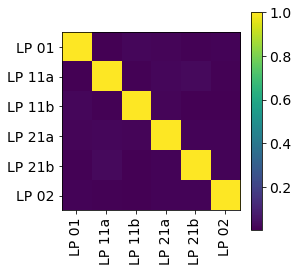

In [4]:
#orthogonality analysis
dotproducts = np.zeros((6,6))
for n in range(6):
    for m in range(6):
        dotproducts[n,m] = np.vdot(lant_modes[n],lant_modes[m])
        
plt.figure(figsize=[4,4])
plt.imshow(np.abs(dotproducts))
plt.colorbar()
plt.xticks(range(6),labels=lp_mode_names,rotation='vertical')
plt.yticks(range(6),labels=lp_mode_names)

idx = np.where(~np.eye(6,dtype=bool))
print(np.median(np.abs(dotproducts[idx])))

In [5]:
#Simulate predicted coupling maps

grid_size = 200
pupil_grid = make_pupil_grid(grid_size)

circ = circular_aperture(diameter=1)
aperture = circ(pupil_grid)

focal_dim = modes_shaped.shape[1]
focal_extent = 4.4
focal_grid = make_uniform_grid([focal_dim,focal_dim],[focal_extent,focal_extent])
prop = FraunhoferPropagator(pupil_grid, focal_grid)
dx = focal_grid.x[1]-focal_grid.x[0]
dxi = pupil_grid.x[1]-pupil_grid.x[0]

lant_modes = []
for n in range(num_modes):
    lant_modes.append(Field(modes_shaped[n].ravel(),focal_grid))

empirical_scale_fac = 1.1233333333333333 #from image registration
num_pix = 31
xshift_pix = -0.58333333 #from image registration
yshift_pix = 0.1 #from image registration
x = np.linspace(-2,2,num_pix)*empirical_scale_fac
y = np.linspace(-2,2,num_pix)*empirical_scale_fac
xshift_physical = xshift_pix/num_pix*(np.max(x)-np.min(x))
yshift_physical = yshift_pix/num_pix*(np.max(y)-np.min(y))
x = xshift_physical+x
y = yshift_physical+y

loD_per_pix = (np.max(x)-np.min(x))/num_pix #calculates lambda/D per pixel
port_stepsize = 0.0015 #um/pixel
micron_to_loD = port_stepsize/loD_per_pix #calculates microns/(lambda/D)

coupling_donuts = np.zeros((num_modes,len(x),len(y)))
for i,xi in enumerate(x):
    for j,yj in enumerate(y):
        coupling_donuts[:,i,j] = prop_6p_vfn_c0(prop,lant_modes,dx,dxi,wfe=None,tt_x=xi,tt_y=yj)

/var/folders/fh/y35_z7xx69qcg_1dsr5v411w0000gn/T/ipykernel_46464/1379630699.py:6: DeprecationWarning: circular_aperture is deprecated. Its new name is make_circular_aperture.
  circ = circular_aperture(diameter=1)


In [6]:
#Simulate fine coupling maps
focal_dim = modes_shaped.shape[1]
focal_extent = 4.4
focal_grid = make_uniform_grid([focal_dim,focal_dim],[focal_extent,focal_extent])
prop = FraunhoferPropagator(pupil_grid, focal_grid)
dx = focal_grid.x[1]-focal_grid.x[0]
dxi = pupil_grid.x[1]-pupil_grid.x[0]

lant_modes = []
for n in range(num_modes):
    lant_modes.append(Field(modes_shaped[n].ravel(),focal_grid))

x = np.linspace(-2/5,2/5,31)*empirical_scale_fac+xshift_physical
y = np.linspace(-2/5,2/5,31)*empirical_scale_fac+yshift_physical

fine_coupling_donuts = np.zeros((num_modes,len(x),len(y)))
for i,xi in enumerate(x):
    for j,yj in enumerate(y):
        fine_coupling_donuts[:,i,j] = prop_6p_vfn_c0(prop,lant_modes,dx,dxi,wfe=None,tt_x=xi,tt_y=yj)

In [7]:
#Rotate simulations to match data
rotation_angle = 205-2 #from image registration

rotated_sims = []
for n in range(len(lant_modes)):
    new_sim = np.flip(coupling_donuts[n],axis=0)
    new_sim = ndimage.rotate(new_sim, rotation_angle,reshape=False)
    rotated_sims.append(new_sim)

0.42117107906387563
0.3853070522381605
0.38424086971166405
0.137631890092489
0.12961509850810432
0.16027835757981784


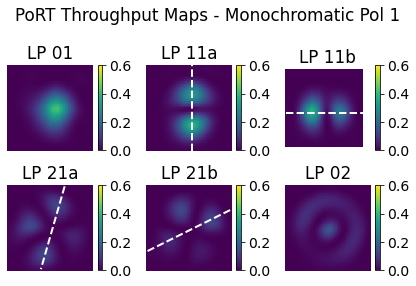

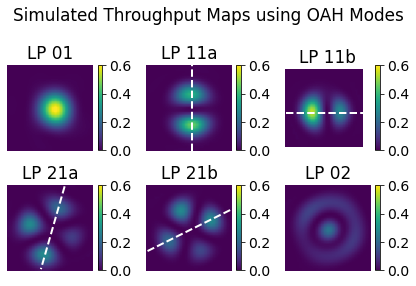

In [8]:
#Plot measured coupling profiles (Monochromatic Pol 1)
lp01_meas = fits.getdata('Lantern_Data/LP01_pol1_30x30_NORMREDU.fits')
lp11a_meas = fits.getdata('Lantern_Data/LP11a_pol1_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data/LP11b_pol1_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data/LP21a_pol1_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data/LP21b_pol1_30x30_NORMREDU.fits')
lp02_meas = fits.getdata('Lantern_Data/LP02_pol1_30x30_NORMREDU.fits')

lp11a_mono1 = lp11a_meas.copy()
lp11b_mono1 = lp11b_meas.copy()
lp21a_mono1 = lp21a_meas.copy()
lp21b_mono1 = lp21b_meas.copy()

port_measurements = np.array([lp01_meas,lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas,lp02_meas])
port_measurements = port_measurements

plt.figure()
for n in range(len(lant_modes)):
    plt.subplot(2,3,n+1)
    plt.imshow(port_measurements[n],vmin=0,vmax=0.6)
    if n==1:
        plt.axvline(16, color='white', linestyle='--',linewidth=2)
    if n==2:
        plt.hlines(17,0,32,colors=['white'],linestyle='--',linewidth=2)
    if n==3:
        plt.plot([20.3,32-(20.3)],[0,30],color='white',linestyle='--',linewidth=2)
    if n==4:
        plt.plot([0,30],[16+7.44,16-7.44],color='white',linestyle='--',linewidth=2)
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n])
plt.suptitle('PoRT Throughput Maps - Monochromatic Pol 1')
plt.tight_layout()

plt.figure()
for n in range(len(lant_modes)):
    plt.subplot(2,3,n+1)
    plt.imshow(rotated_sims[n],vmin=0,vmax=0.6)
    if n==1:
        plt.axvline(16, color='white', linestyle='--',linewidth=2)
    if n==2:
        plt.hlines(17,0,32,colors=['white'],linestyle='--',linewidth=2)
    if n==3:
        plt.plot([20.3,32-(20.3)],[0,30],color='white',linestyle='--',linewidth=2)
    if n==4:
        plt.plot([0,30],[16+7.44,16-7.44],color='white',linestyle='--',linewidth=2)
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n])
plt.suptitle('Simulated Throughput Maps using OAH Modes')
plt.tight_layout()

print(np.max(port_measurements[0]))
print(np.max(port_measurements[1]))
print(np.max(port_measurements[2]))
print(np.max(port_measurements[3]))
print(np.max(port_measurements[4]))
print(np.max(port_measurements[5]))

added_maps = port_measurements[1]+port_measurements[2]+port_measurements[3]+port_measurements[4]

peak_eta_ps = [np.max(port_measurements[1]),np.max(port_measurements[2]),np.max(port_measurements[3]),np.max(port_measurements[4])]

(16, 17)
0.46141707859091874
0.39556445342417124
0.37681260230906
0.14611832998899424
0.1404668771721235
0.17091680943676044


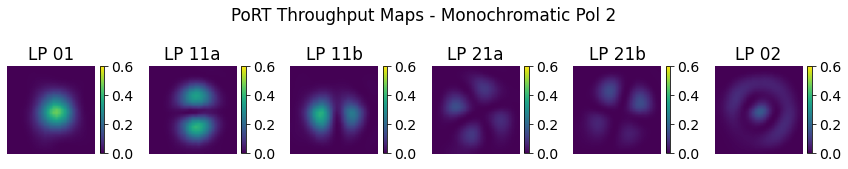

In [9]:
#Monochromatic results Pol 2
lp01_meas = fits.getdata('Lantern_Data/LP01_pol2_30x30_NORMREDU.fits')
lp11a_meas = fits.getdata('Lantern_Data/LP11a_pol2_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data/LP11b_pol2_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data/LP21a_pol2_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data/LP21b_pol2_30x30_NORMREDU.fits')
lp02_meas = fits.getdata('Lantern_Data/LP02_pol2_30x30_NORMREDU.fits')

lp11a_mono2 = lp11a_meas.copy()
lp11b_mono2 = lp11b_meas.copy()
lp21a_mono2 = lp21a_meas.copy()
lp21b_mono2 = lp21b_meas.copy()

print(np.unravel_index(np.argmax(lp01_meas),lp11b_meas.shape))

port_measurements = np.array([lp01_meas,lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas,lp02_meas])

plt.figure(figsize=([12,2.5]))
for n in range(len(lant_modes)):
    plt.subplot(1,6,n+1)
    plt.imshow(port_measurements[n],vmin=0,vmax=0.6)
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n])
plt.suptitle('PoRT Throughput Maps - Monochromatic Pol 2')
plt.tight_layout()

print(np.max(port_measurements[0]))
print(np.max(port_measurements[1]))
print(np.max(port_measurements[2]))
print(np.max(port_measurements[3]))
print(np.max(port_measurements[4]))
print(np.max(port_measurements[5]))

22
17
0.000732114015786381
0.003652652686126652
0.0059102302197415885
0.0009048126950572578
0.0015926120664120202
0.006688782167156777
0.020478176188765292
0.0031834086405113237


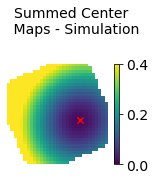

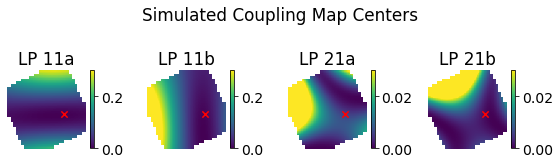

In [10]:
#Plot simulated fine maps

fine_rotated_sims = []
for n in range(len(lant_modes)):
    new_sim = np.flip(fine_coupling_donuts[n],axis=0)
    new_sim = ndimage.rotate(new_sim, rotation_angle,reshape=False)
    new_sim[new_sim==0] = np.nan
    fine_rotated_sims.append(new_sim)

fine_rotated_sims = np.array(fine_rotated_sims)
added_maps = fine_rotated_sims[1]+fine_rotated_sims[2]+fine_rotated_sims[3]+fine_rotated_sims[4]

center_y,center_x = np.unravel_index(np.nanargmin(added_maps),lp11a_meas.shape)
print(center_x)
print(center_y)

plt.figure(figsize=[2.5,2.5])
plt.scatter(center_x,center_y,marker='x',s=40,c='red')
plt.imshow(added_maps,vmin=0,vmax=0.4)

plt.suptitle('Summed Center \n Maps - Simulation',fontsize=14)
plt.axis('off')
plt.colorbar(fraction = 0.045)
plt.tight_layout()

vmaxes = [0.3,0.3,0.03,0.03]
plt.figure(figsize=([8,2.5]))
for n in range(4):
    plt.subplot(1,4,n+1)
    plt.scatter(center_x,center_y,marker='x',s=40,c='red')
    plt.imshow(fine_rotated_sims[n+1],vmin=0,vmax=vmaxes[n])
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n+1])
plt.suptitle('Simulated Coupling Map Centers')
plt.tight_layout()

print(fine_rotated_sims[1,center_y,center_x])
print(fine_rotated_sims[2,center_y,center_x])
print(fine_rotated_sims[3,center_y,center_x])
print(fine_rotated_sims[4,center_y,center_x])

print(fine_rotated_sims[1,center_y,center_x]/np.max(coupling_donuts[1]))
print(fine_rotated_sims[2,center_y,center_x]/np.max(coupling_donuts[2]))
print(fine_rotated_sims[3,center_y,center_x]/np.max(coupling_donuts[3]))
print(fine_rotated_sims[4,center_y,center_x]/np.max(coupling_donuts[4]))

(18, 20)
0.0040527465315390535
0.026446285817410795
0.0028500064213565044
0.0017751170519057081
0.010518225680006573
0.06882736299565478
0.020707456821535273
0.013695295319277307


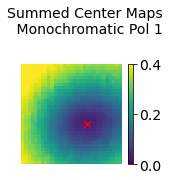

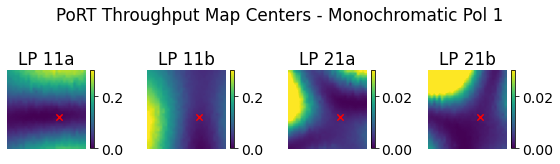

In [11]:
#Plot fine scans Monochromatic Pol 1
lp11a_meas = fits.getdata('Lantern_Data/LP11a_pol1_zoom5_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data/LP11b_pol1_zoom5_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data/LP21a_pol1_zoom5_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data/LP21b_pol1_zoom5_30x30_NORMREDU.fits')

port_measurements = np.array([lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas])

added_maps = port_measurements[0]+port_measurements[1]+port_measurements[2]+port_measurements[3]

print(np.unravel_index(np.argmin(added_maps),lp11a_meas.shape))

center_y,center_x = np.unravel_index(np.argmin(added_maps),lp11a_meas.shape)

plt.figure(figsize=[2.5,2.5])
plt.scatter(center_x,center_y,marker='x',s=40,c='red')
plt.imshow(added_maps,vmin=0,vmax=0.4)

plt.suptitle('Summed Center Maps \n Monochromatic Pol 1',fontsize=14)
plt.axis('off')
plt.colorbar(fraction = 0.045)
plt.tight_layout()

vmaxes = [0.3,0.3,0.03,0.03]
plt.figure(figsize=([8,2.5]))
for n in range(4):
    plt.subplot(1,4,n+1)
    plt.scatter(center_x,center_y,marker='x',s=40,c='red')
    plt.imshow(port_measurements[n],vmin=0,vmax=vmaxes[n])
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n+1])
plt.suptitle('PoRT Throughput Map Centers - Monochromatic Pol 1')
plt.tight_layout()

print(port_measurements[0,center_y,center_x])
print(port_measurements[1,center_y,center_x])
print(port_measurements[2,center_y,center_x])
print(port_measurements[3,center_y,center_x])

print(port_measurements[0,center_y,center_x]/peak_eta_ps[0])
print(port_measurements[1,center_y,center_x]/peak_eta_ps[1])
print(port_measurements[2,center_y,center_x]/peak_eta_ps[2])
print(port_measurements[3,center_y,center_x]/peak_eta_ps[3])

fine_scans_mono_pol1 = port_measurements.copy()

(18, 20)
0.006526272964026021
0.030028592709027364
0.0005117481898612182
0.0010679675422064364
0.01693784976453557
0.07815043915437976
0.0037182384803211093
0.008239530382640265


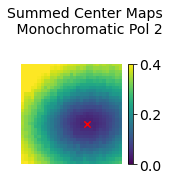

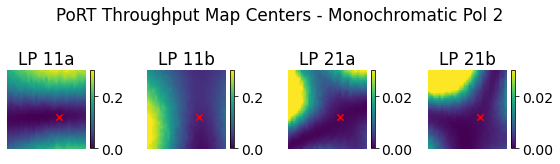

In [12]:
#Plot fine scans Monochromatic Pol 2
lp11a_meas = fits.getdata('Lantern_Data/LP11a_pol2_zoom5_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data/LP11b_pol2_zoom5_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data/LP21a_pol2_zoom5_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data/LP21b_pol2_zoom5_30x30_NORMREDU.fits')

port_measurements = np.array([lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas])

added_maps = port_measurements[0]+port_measurements[1]+port_measurements[2]+port_measurements[3]

print(np.unravel_index(np.argmin(added_maps),lp11a_meas.shape))

center_y,center_x = np.unravel_index(np.argmin(added_maps),lp11a_meas.shape)

plt.figure(figsize=[2.5,2.5])
plt.scatter(center_x,center_y,marker='x',s=40,c='red')
plt.imshow(added_maps,vmin=0,vmax=0.4)

plt.suptitle('Summed Center Maps \n Monochromatic Pol 2',fontsize=14)
plt.axis('off')
plt.colorbar(fraction = 0.045)
plt.tight_layout()

vmaxes = [0.3,0.3,0.03,0.03]
plt.figure(figsize=([8,2.5]))
for n in range(4):
    plt.subplot(1,4,n+1)
    plt.scatter(center_x,center_y,marker='x',s=40,c='red')
    plt.imshow(port_measurements[n],vmin=0,vmax=vmaxes[n])
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n+1])
plt.suptitle('PoRT Throughput Map Centers - Monochromatic Pol 2')
plt.tight_layout()

print(port_measurements[0,center_y,center_x])
print(port_measurements[1,center_y,center_x])
print(port_measurements[2,center_y,center_x])
print(port_measurements[3,center_y,center_x])

print(port_measurements[0,center_y,center_x]/peak_eta_ps[0])
print(port_measurements[1,center_y,center_x]/peak_eta_ps[1])
print(port_measurements[2,center_y,center_x]/peak_eta_ps[2])
print(port_measurements[3,center_y,center_x]/peak_eta_ps[3])

fine_scans_mono_pol2 = port_measurements.copy()

(15, 16)
0.4379615624742968
0.4041763460874938
0.3740580571799103
0.13218315441867234
0.12429072775453898
0.176771641380465


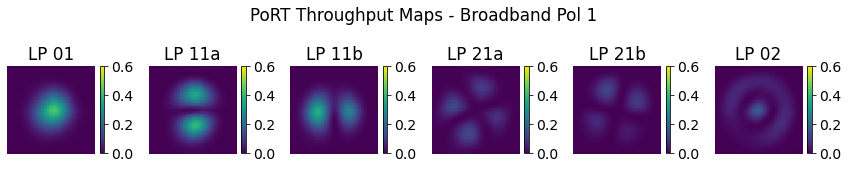

In [13]:
#Broadband results Pol 1
lp01_meas = fits.getdata('Lantern_Data_Broadband/LP01_pol1_30x30_NORMREDU.fits')
lp11a_meas = fits.getdata('Lantern_Data_Broadband/LP11a_pol1_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data_Broadband/LP11b_pol1_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data_Broadband/LP21a_pol1_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data_Broadband/LP21b_pol1_30x30_NORMREDU.fits')
lp02_meas = fits.getdata('Lantern_Data_Broadband/LP02_pol1_30x30_NORMREDU.fits')

lp11a_broad1 = lp11a_meas.copy()
lp11b_broad1 = lp11b_meas.copy()
lp21a_broad1 = lp21a_meas.copy()
lp21b_broad1 = lp21b_meas.copy()

print(np.unravel_index(np.argmax(lp01_meas),lp11b_meas.shape))

port_measurements = np.array([lp01_meas,lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas,lp02_meas])

plt.figure(figsize=([12,2.5]))
for n in range(len(lant_modes)):
    plt.subplot(1,6,n+1)
    plt.imshow(port_measurements[n],vmin=0,vmax=0.6)
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n])
plt.suptitle('PoRT Throughput Maps - Broadband Pol 1')
plt.tight_layout()

print(np.max(port_measurements[0]))
print(np.max(port_measurements[1]))
print(np.max(port_measurements[2]))
print(np.max(port_measurements[3]))
print(np.max(port_measurements[4]))
print(np.max(port_measurements[5]))

peak_eta_ps = [np.max(port_measurements[1]),np.max(port_measurements[2]),np.max(port_measurements[3]),np.max(port_measurements[4])]

(16, 15)
0.007978777997236803
0.03459750551872666
0.0025484071078010666
0.0012646190076052697
0.019740833610063867
0.09249234137492815
0.01927936369054509
0.010174685034452114


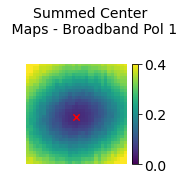

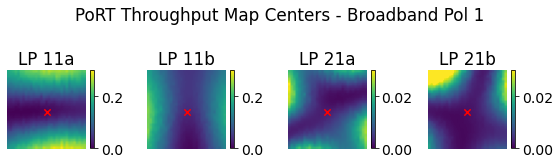

In [14]:
#Plot fine scans Broadband Pol 1
lp11a_meas = fits.getdata('Lantern_Data_Broadband/LP11a_pol1_zoom5_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data_Broadband/LP11b_pol1_zoom5_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data_Broadband/LP21a_pol1_zoom5_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data_Broadband/LP21b_pol1_zoom5_30x30_NORMREDU.fits')

port_measurements = np.array([lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas])

added_maps = port_measurements[0]+port_measurements[1]+port_measurements[2]+port_measurements[3]

print(np.unravel_index(np.argmin(added_maps),added_maps.shape))

center_y,center_x = np.unravel_index(np.argmin(added_maps),added_maps.shape)

plt.figure(figsize=[2.5,2.5])
plt.scatter(center_x,center_y,marker='x',s=40,c='red')
plt.imshow(added_maps,vmin=0,vmax=0.4)

plt.suptitle('Summed Center \n Maps - Broadband Pol 1',fontsize=14)
plt.axis('off')
plt.colorbar(fraction = 0.045)
plt.tight_layout()

vmaxes = [0.3,0.3,0.03,0.03]
plt.figure(figsize=([8,2.5]))
for n in range(4):
    plt.subplot(1,4,n+1)
    plt.scatter(center_x,center_y,marker='x',s=40,c='red')
    plt.imshow(port_measurements[n],vmin=0,vmax=vmaxes[n])
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n+1])
plt.suptitle('PoRT Throughput Map Centers - Broadband Pol 1')
plt.tight_layout()

print(port_measurements[0,center_y,center_x])
print(port_measurements[1,center_y,center_x])
print(port_measurements[2,center_y,center_x])
print(port_measurements[3,center_y,center_x])

print(port_measurements[0,center_y,center_x]/peak_eta_ps[0])
print(port_measurements[1,center_y,center_x]/peak_eta_ps[1])
print(port_measurements[2,center_y,center_x]/peak_eta_ps[2])
print(port_measurements[3,center_y,center_x]/peak_eta_ps[3])

fine_scans_broad_pol1 = port_measurements.copy()

(15, 16)
0.4509270546202948
0.38685260036713554
0.3855774316743953
0.13286545545249318
0.12916962087638162
0.20502068863249953


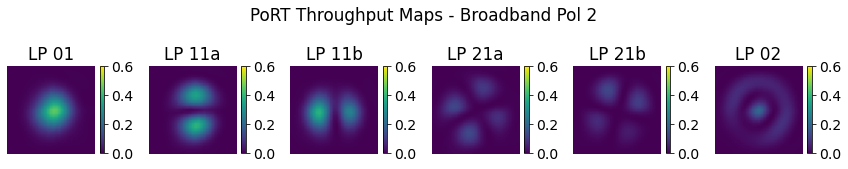

In [15]:
#Broadband results Pol 2
lp01_meas = fits.getdata('Lantern_Data_Broadband/LP01_pol2_30x30_NORMREDU.fits')
lp11a_meas = fits.getdata('Lantern_Data_Broadband/LP11a_pol2_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data_Broadband/LP11b_pol2_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data_Broadband/LP21a_pol2_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data_Broadband/LP21b_pol2_30x30_NORMREDU.fits')
lp02_meas = fits.getdata('Lantern_Data_Broadband/LP02_pol2_30x30_NORMREDU.fits')

lp11a_broad2 = lp11a_meas.copy()
lp11b_broad2 = lp11b_meas.copy()
lp21a_broad2 = lp21a_meas.copy()
lp21b_broad2 = lp21b_meas.copy()

print(np.unravel_index(np.argmax(lp01_meas),lp11b_meas.shape))

port_measurements = np.array([lp01_meas,lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas,lp02_meas])

plt.figure(figsize=([12,2.5]))
for n in range(len(lant_modes)):
    plt.subplot(1,6,n+1)
    plt.imshow(port_measurements[n],vmin=0,vmax=0.6)
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n])
plt.suptitle('PoRT Throughput Maps - Broadband Pol 2')
plt.tight_layout()

print(np.max(port_measurements[0]))
print(np.max(port_measurements[1]))
print(np.max(port_measurements[2]))
print(np.max(port_measurements[3]))
print(np.max(port_measurements[4]))
print(np.max(port_measurements[5]))

peak_eta_ps = [np.max(port_measurements[1]),np.max(port_measurements[2]),np.max(port_measurements[3]),np.max(port_measurements[4])]

(17, 17)
0.008540142568701746
0.032385899105349475
0.0025157641413786004
0.001340563615100039
0.022075960095904425
0.08399324349641415
0.018934674425423747
0.010378319654456446


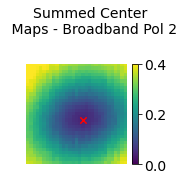

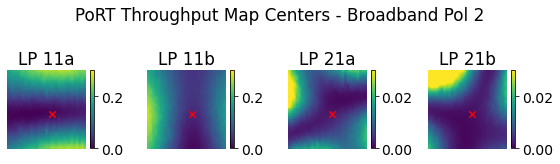

In [16]:
#Plot fine scans Broadband Pol 2
lp11a_meas = fits.getdata('Lantern_Data_Broadband/LP11a_pol2_zoom5_30x30_NORMREDU.fits')
lp11b_meas = fits.getdata('Lantern_Data_Broadband/LP11b_pol2_zoom5_30x30_NORMREDU.fits')
lp21a_meas = fits.getdata('Lantern_Data_Broadband/LP21a_pol2_zoom5_30x30_NORMREDU.fits')
lp21b_meas = fits.getdata('Lantern_Data_Broadband/LP21b_pol2_zoom5_30x30_NORMREDU.fits')

port_measurements = np.array([lp11a_meas,lp11b_meas,lp21a_meas,lp21b_meas])

added_maps = port_measurements[0]+port_measurements[1]+port_measurements[2]+port_measurements[3]

print(np.unravel_index(np.argmin(added_maps),added_maps.shape))

center_y,center_x = np.unravel_index(np.argmin(added_maps),added_maps.shape)

plt.figure(figsize=[2.5,2.5])
plt.scatter(center_x,center_y,marker='x',s=40,c='red')
plt.imshow(added_maps,vmin=0,vmax=0.4)

plt.suptitle('Summed Center \n Maps - Broadband Pol 2',fontsize=14)
plt.axis('off')
plt.colorbar(fraction = 0.045)
plt.tight_layout()

vmaxes = [0.3,0.3,0.03,0.03]
plt.figure(figsize=([8,2.5]))
for n in range(4):
    plt.subplot(1,4,n+1)
    plt.scatter(center_x,center_y,marker='x',s=40,c='red')
    plt.imshow(port_measurements[n],vmin=0,vmax=vmaxes[n])
    plt.axis('off')
    plt.colorbar(fraction = 0.045)
    plt.title(lp_mode_names[n+1])
plt.suptitle('PoRT Throughput Map Centers - Broadband Pol 2')
plt.tight_layout()


print(port_measurements[0,center_y,center_x])
print(port_measurements[1,center_y,center_x])
print(port_measurements[2,center_y,center_x])
print(port_measurements[3,center_y,center_x])

print(port_measurements[0,center_y,center_x]/peak_eta_ps[0])
print(port_measurements[1,center_y,center_x]/peak_eta_ps[1])
print(port_measurements[2,center_y,center_x]/peak_eta_ps[2])
print(port_measurements[3,center_y,center_x]/peak_eta_ps[3])

fine_scans_broad_pol2 = port_measurements.copy()

0.001320719324424999


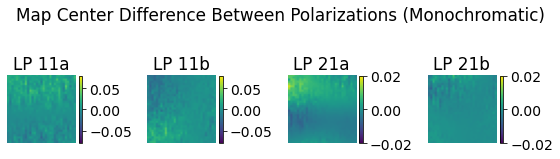

In [17]:
#Difference maps monochromatic (pol2-pol1)
diff_maps_mono = fine_scans_mono_pol2-fine_scans_mono_pol1

diff_vmin = -0.08
diff_vmax = 0.08

diff_vmin_2 = -0.02
diff_vmax_2 = 0.02

plt.figure(figsize=([8,2.5]))
plt.subplot(1,4,1)
plt.imshow(diff_maps_mono[0],vmin=diff_vmin,vmax=diff_vmax)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 11a')
plt.subplot(1,4,2)
plt.imshow(diff_maps_mono[1],vmin=diff_vmin,vmax=diff_vmax)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 11b')
plt.subplot(1,4,3)
plt.imshow(diff_maps_mono[2],vmin=diff_vmin_2,vmax=diff_vmax_2)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 21a')
plt.subplot(1,4,4)
plt.imshow(diff_maps_mono[3],vmin=diff_vmin_2,vmax=diff_vmax_2)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 21b')
plt.suptitle('Map Center Difference Between Polarizations (Monochromatic)')
plt.tight_layout()

print(np.std(diff_maps_mono[3]))

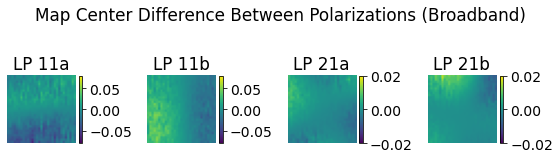

In [18]:
#Difference maps broadband (pol2-pol1)
diff_maps_broad = fine_scans_broad_pol2-fine_scans_broad_pol1

plt.figure(figsize=([8,2.5]))
plt.subplot(1,4,1)
plt.imshow(diff_maps_broad[0],vmin=diff_vmin,vmax=diff_vmax)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 11a')
plt.subplot(1,4,2)
plt.imshow(diff_maps_broad[1],vmin=diff_vmin,vmax=diff_vmax)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 11b')
plt.subplot(1,4,3)
plt.imshow(diff_maps_broad[2],vmin=diff_vmin_2,vmax=diff_vmax_2)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 21a')
plt.subplot(1,4,4)
plt.imshow(diff_maps_broad[3],vmin=diff_vmin_2,vmax=diff_vmax_2)
plt.colorbar(fraction = 0.045)
plt.axis('off')
plt.title('LP 21b')
plt.suptitle('Map Center Difference Between Polarizations (Broadband)')
plt.tight_layout()

In [19]:
#Find optimal lantern r for a lantern with perfect LP modes (used for cross-section plots)

focal_dim = modes_shaped.shape[1]
focal_extent = 4.4
focal_grid = make_uniform_grid([focal_dim,focal_dim],[focal_extent,focal_extent])
prop = FraunhoferPropagator(pupil_grid, focal_grid)
dx = focal_grid.x[1]-focal_grid.x[0]
dxi = pupil_grid.x[1]-pupil_grid.x[0]

test_rs = np.linspace(0.5,1.5,21)
x_xsec = np.linspace(-2,2,num_pix)*empirical_scale_fac
lp11a_xsecs = np.zeros((len(test_rs),len(x_xsec)))

for m in range(len(test_rs)):
    lp_modes_c0 = make_lp_modes(focal_grid,1.5*np.pi,test_rs[m])
    
    for i,xi in enumerate(x_xsec):
        outputs = prop_6p_vfn_c0_normLP(prop,lp_modes_c0,dx,dxi,wfe=None,tt_x=0,tt_y=x_xsec[i])
        lp11a_xsecs[m,i] = outputs[1]

In [20]:
#Make perfect lantern cross section to plot
idcs = np.unravel_index(np.argmax(lp11a_xsecs),lp11a_xsecs.shape)
best_r = test_rs[idcs[0]]
lp_modes_c0 = make_lp_modes(focal_grid,1.5*np.pi,best_r)

perfect_LP11_xsecs = []
perfect_LP21_xsecs = []
for i,xi in enumerate(x_xsec):    
        outputs = prop_6p_vfn_c0_normLP(prop,lp_modes_c0,dx,dxi,wfe=None,tt_x=0,tt_y=x_xsec[i])
        perfect_LP11_xsecs.append(outputs[1])
        perfect_LP21_xsecs.append(outputs[4])
perfect_LP11_xsecs = np.array(perfect_LP11_xsecs)
perfect_LP21_xsecs = np.array(perfect_LP21_xsecs)

In [21]:
#calc LP21a cross section (simulated with OAH modes and measured on testbed)
lp21a_rotangle = -73
lp21a_rot = ndimage.rotate(rotated_sims[3],lp21a_rotangle,reshape=False)
lp21a_meas_rot = ndimage.rotate(lp21a_mono1,lp21a_rotangle,reshape=False)

In [22]:
#calc LP21b cross section (simulated with OAH modes and measured on testbed)
lp21b_rotangle = -73+45
lp21b_rot = ndimage.rotate(rotated_sims[4],lp21b_rotangle,reshape=False)
lp21b_meas_rot = ndimage.rotate(lp21b_mono1,lp21b_rotangle,reshape=False)

(21, 16)
(17, 10)


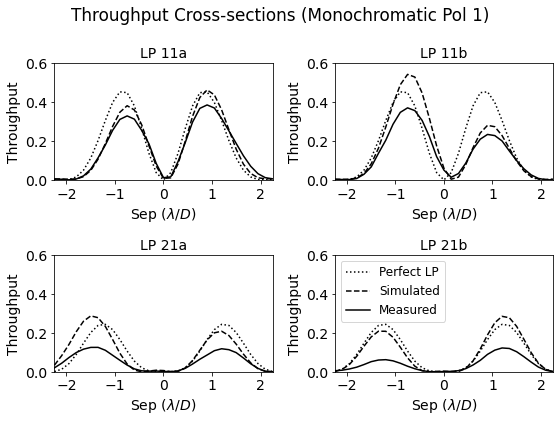

In [23]:
#plot cross-sections
lp11a_argmax = np.unravel_index(np.argmax(rotated_sims[1]),rotated_sims[1].shape)
lp11b_argmax = np.unravel_index(np.argmax(rotated_sims[2]),rotated_sims[2].shape)

print(lp11a_argmax)
print(lp11b_argmax)

plt.figure(figsize=[8,6])

ylim_max = 0.6

plt.subplot(2,2,1)
plt.plot(x_xsec,perfect_LP11_xsecs,':k',label='Perfect LP')
plt.plot(x_xsec,rotated_sims[1][:,16],'--k',label='Simulated')
plt.plot(x_xsec,lp11a_mono1[:,16],'-k',label='Measured')
plt.xlim([x_xsec.min(),x_xsec.max()])
plt.ylim([0,ylim_max])
plt.xlabel('Sep ($\lambda/D$)')
plt.ylabel('Throughput')
plt.title('LP 11a',fontsize=14)

plt.subplot(2,2,2)
plt.plot(x_xsec,perfect_LP11_xsecs,':k',label='Perfect LP')
plt.plot(x_xsec,rotated_sims[2][17,:],'--k',label='Simulated')
plt.plot(x_xsec,lp11b_mono1[17,:],'-k',label='Measured')
plt.xlim([x_xsec.min(),x_xsec.max()])
plt.ylim([0,ylim_max])
plt.xlabel('Sep ($\lambda/D$)')
plt.ylabel('Throughput')
plt.title('LP 11b',fontsize=14)

plt.subplot(2,2,3)
plt.plot(x_xsec,perfect_LP21_xsecs,':k',label='Perfect LP')
plt.plot(x_xsec,lp21a_rot[16,:],'--k',label='Simulated')
plt.plot(x_xsec,lp21a_meas_rot[16,:],'-k',label='Measured')
plt.xlim([x_xsec.min(),x_xsec.max()])
plt.ylim([0,ylim_max])
plt.xlabel('Sep ($\lambda/D$)')
plt.ylabel('Throughput')
plt.title('LP 21a',fontsize=14)

plt.subplot(2,2,4)
plt.plot(x_xsec,perfect_LP21_xsecs,':k',label='Perfect LP')
plt.plot(x_xsec,lp21b_rot[16,:],'--k',label='Simulated')
plt.plot(x_xsec,lp21b_meas_rot[16,:],'-k',label='Measured')
plt.xlim([x_xsec.min(),x_xsec.max()])
plt.ylim([0,ylim_max])
plt.xlabel('Sep ($\lambda/D$)')
plt.ylabel('Throughput')
plt.title('LP 21b',fontsize=14)

plt.legend(fontsize=12)
plt.suptitle('Throughput Cross-sections (Monochromatic Pol 1)')
plt.tight_layout()